# Mart Tutor Assistant

Reference:

- [Assistants OpenAI Overview](https://platform.openai.com/docs/assistants/overview)
- [Github-OpenAI Python/examples/Assistant demo notebook](https://github.com/openai/openai-python/blob/main/examples/assistant.py)


## Load the required libraries

In [1]:
import time
from datetime import datetime
import os
import io

from PIL import Image
from dotenv import load_dotenv
from openai import AzureOpenAI
from openai.types.beta.threads.message_content_text import MessageContentText
from openai.types.beta.threads.message_content_image_file import MessageContentImageFile

## Load the environment variables

In [2]:
load_dotenv()
api_endpoint = os.getenv("OPENAI_URI")
api_key = os.getenv("OPENAI_KEY")
api_version = os.getenv("OPENAI_VERSION")
api_deployment_name = os.getenv("OPENAI_GPT_DEPLOYMENT")

### Create an Azure OpenAI client

In [3]:
client = AzureOpenAI(api_key=api_key,
        api_version=api_version,
        azure_endpoint=api_endpoint)

### Create an Assistant and a Thread

In [4]:
assistant = client.beta.assistants.create(
    name="Math Tutor",
    instructions="You are a personal math tutor. Write and run code to answer math questions.",
    tools=[{"type": "code_interpreter"}],
    model=api_deployment_name
)

thread = client.beta.threads.create()

### Format and display the Assistant Messages for text and images

In [5]:
def format_messages(messages):
    message_list = []

    # Get all the messages till the last user message
    for message in messages:
        message_list.append(message)
        if message.role == "user":
            break

    # Reverse the messages to show the last user message first
    message_list.reverse()

    # Print the user or Assistant messages or images
    for message in message_list:                
        for item in message.content:
            # Determine the content type
            if isinstance(item, MessageContentText):
                print(f'{message.role}:\n{item.text.value}\n')
            elif isinstance(item, MessageContentImageFile):
                # Retrieve image from file id
                response_content = client.files.content(item.image_file.file_id)
                data_in_bytes = response_content.read()
                # Convert bytes to image
                readable_buffer = io.BytesIO(data_in_bytes)
                image = Image.open(readable_buffer)
                # Resize image to fit in terminal
                width, height = image.size
                image = image.resize((width //2, height //2), Image.LANCZOS)
                # Display image
                image.show()

### Process the user messages

In [6]:
def process_message(content:str):
    client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content=content
    )
    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
        instructions="Please address the user as Jane Doe. The user has a premium account. Be assertive, accurate, and polite. Ask if the user has further questions. " + 
        "The current date and time is: " + datetime.now().strftime("%x %X") + ". "
    )
    print("processing ...")
    while True:
        run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
        if run.status == "completed":
            # Handle completed
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            break
        elif run.status == "failed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            answer = messages.data[0].content[0].text.value
            print(f'Failed User:\n{content}\nAssistant:\n{answer}\n')
            # Handle failed
            break
        elif run.status == "expired":
            # Handle expired
            print(run)
            break
        elif run.status == "cancelled":
            # Handle cancelled
            print(run)            
            break
        elif run.status == "requires_action":
            # Handle function calling and continue processing
            pass
        else:
            time.sleep(5)

### Have a conversation with the Assistant

In [7]:
process_message("What is the linear equation when two (x,y) points are (1,1) and (5,10)?")

processing ...
user:
What is the linear equation when two (x,y) points are (1,1) and (5,10)?

assistant:
To find the equation of a straight line given two points \((x_1, y_1)\) and \((x_2, y_2)\), you can use the formula for the slope (m) of the line:

\[ m = \frac{y_2 - y_1}{x_2 - x_1} \]

Once you have the slope, you can use either of the two points and the slope to write the equation of the line in point-slope form:

\[ y - y_1 = m(x - x_1) \]

This can then be simplified to the slope-intercept form (y = mx + b) if desired.

Let's calculate the slope using the points (1,1) and (5,10).

assistant:
The slope (m) of the line that passes through the points (1,1) and (5,10) is 2.25.

We can now use the point-slope form to derive the equation of the line:

\[ y - y_1 = m(x - x_1) \]

Plugging in the slope and one of the points, (1, 1), to the point-slope form, we get:

\[ y - 1 = 2.25(x - 1) \]

Let me simplify this into the slope-intercept form (y = mx + b).

assistant:
The equation of t

In [8]:

process_message("I need to solve the equation `3x + 11 = 14`. Can you help me?")

processing ...
user:
I need to solve the equation `3x + 11 = 14`. Can you help me?

assistant:
Certainly! To solve the equation \(3x + 11 = 14\), we need to isolate the variable \(x\). Here are the steps:

1. Subtract 11 from both sides of the equation to move the constant term to the right side.
2. Divide both sides by 3 to solve for \(x\).

Allow me to compute that for you.

assistant:
The solution to the equation \(3x + 11 = 14\) is \(x = 1\).

Please let me know if there's anything else I can help you with, Jane Doe!



processing ...
user:
x=r*cos(u)sin(v)
y=r*sin(u)sin(v)
r=2+sin(7*u+5*v) 

for 0<u<2π and 0<v<π.

Create a graph of the equation z=r*cos(v).

assistant:
To graph the equation \( z = r \cos(v) \), we first need to acknowledge that we'll be graphing in three dimensions because we have three variables: \( x \), \( y \), and \( z \).

Given the parametric equations:
\[ x = r \cos(u) \sin(v) \]
\[ y = r \sin(u) \sin(v) \]
\[ r = 2 + \sin(7u+5v) \]

We'll use these equations to express \( x \) and \( y \) in terms of \( u \) and \( v \), and compute \( r \) based on \( u \) and \( v \) to then calculate \( z \).

Since we have a range for \( u \) from 0 to \( 2\pi \) and \( v \) from 0 to \( \pi \), we will generate a meshgrid of values within these ranges and calculate \( x \), \( y \), and \( z \) accordingly.

Let's plot the graph for the given equations.



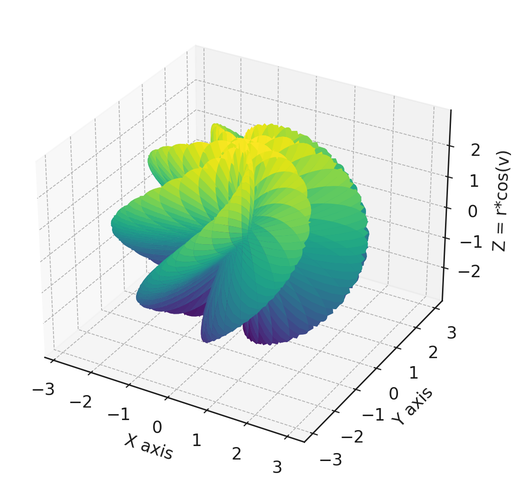

assistant:
Here is the graph of the equation \( z = r \cos(v) \) based on the given parametric representations of \( x \), \( y \), and the definition of \( r \) within the prescribed ranges for \( u \) and \( v \).

If you have any more questions or need further assistance, please feel free to ask, Jane Doe!



In [9]:
process_message("""x=r*cos(u)sin(v)
y=r*sin(u)sin(v)
r=2+sin(7*u+5*v) 

for 0<u<2π and 0<v<π.

Create a graph of the equation z=r*cos(v).""")

### Cleanup

In [10]:
client.beta.assistants.delete(assistant.id)
client.beta.threads.delete(thread.id)

ThreadDeleted(id='thread_D23Utpm7ybxWQTXsyNYOxWqh', deleted=True, object='thread.deleted')